In [9]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gc
from prj.config import DATA_DIR, EXP_DIR
from tqdm import tqdm
from prj.agents.factory import AgentsFactory
import os

In [10]:
agent_base_dir = EXP_DIR / 'tuning'

agents_dict = [
    {'agent_type': 'lgbm', 'load_path': os.path.join(agent_base_dir, "lgbm_1seeds_8_8-9_9_20241209_191818", "best_trial", "saved_model")},
    {'agent_type': 'xgb', 'load_path': os.path.join(agent_base_dir, "xgb_1seeds_8_8-9_9_20241209_190829", "best_trial", "saved_model")},
    {'agent_type': 'catboost', 'load_path': os.path.join(agent_base_dir, "catboost_1seeds_8_8-9_9_20241209_190401", "best_trial", "saved_model")},
    # {'agent_type': 'mlp', 'load_path': os.path.join(agent_base_dir, "mlp_1seeds_8_8-9_9_20241209_191428", "best_trial", "saved_model")},
    # {'agent_type': 'lgbm', 'load_path': os.path.join(agent_base_dir, "LGBMRegressor_1seeds_7_8-9_9_134923", "best_trial", "saved_model")},
    # {'agent_type': 'xgb', 'load_path': os.path.join(agent_base_dir, "xgb_5-5_20241119_222538", "models")},

]
agents = [AgentsFactory.load_agent(agent_dict) for agent_dict in agents_dict]

len(agents)

Loading models, overwriting seeds: [1475374378]
Loading models, overwriting seeds: [729746924]
Loading models, overwriting seeds: [325885417]


3

In [11]:
from prj.data.data_loader import DataLoader


# data_args = {'ffill': False, 'include_symbol_id': False}
# loader = DataLoader(**data_args)
# X, y, w, info = loader.load_partitions(start_partition=9, end_partition=9)
# np.savez(DATA_DIR / 'x_9_9.npz', X=X, y=y, w=w, info=info)

data = np.load(DATA_DIR / 'x_9_9.npz')
X = data['X']
y = data['y']
w = data['w']
info = data['info']

# f = 100000
# X = X[:f]
# y = y[:f]
# w = w[:f]
# info = info[:f]

gc.collect()

X.shape, y.shape, w.shape, info.shape

((6274576, 79), (6274576,), (6274576,), (6274576, 3))

In [12]:
def squared_weighted_error_loss_fn(y_true: np.ndarray, y_pred_agents: np.ndarray, w: np.ndarray) -> np.ndarray:
    return w.reshape(-1, 1) * ((y_true.reshape(-1, 1) - y_pred_agents) ** 2)

def absolute_weighted_error_loss_fn(y_true: np.ndarray, y_pred_agents: np.ndarray, w: np.ndarray) -> np.ndarray:
    return w.reshape(-1, 1) * np.abs(y_true.reshape(-1, 1) - y_pred_agents)

def compute_loss(y_true: np.ndarray, y_pred_agents: np.ndarray, w: np.ndarray, loss_fn) -> np.ndarray:
    assert y_true.shape[0] == y_pred_agents.shape[0]
    if w is None:
        w = np.ones_like(y_true)
    assert y_true.shape[0] == w.shape[0]

    return loss_fn(y_true, y_pred_agents, w)


agents_predictions = np.concatenate([agent.predict(X).reshape(-1, 1) for agent in tqdm(agents)], axis=1)
agents_losses = compute_loss(y, agents_predictions, w, absolute_weighted_error_loss_fn)
agents_predictions.shape, agents_losses.shape, np.any(np.isnan(agents_predictions), axis=1).sum(), np.any(np.isnan(agents_losses), axis=1).sum()

100%|██████████| 3/3 [00:14<00:00,  4.73s/it]


((6274576, 3), (6274576, 3), 0, 0)

In [ ]:

from prj.metrics import weighted_r2
from prj.oamp.oamp import OAMP
from prj.oamp.oamp_config import ConfigOAMP

oamp_args = ConfigOAMP({'agents_weights_upd_freq': 200, 'loss_fn_window': 1000})
n_agents = len(agents)
oamp: OAMP = OAMP(n_agents, oamp_args)

ensemble_preds = []
for i in tqdm(range(agents_predictions.shape[0])):
    time_id_idx = 1
    is_new_group = info[i, time_id_idx] != info[i-1, time_id_idx] if i > 0 else False
    
    ensemble_prediction = oamp.step(agents_losses[i], agents_predictions[i], is_new_group=is_new_group)
    if np.isnan(ensemble_prediction):
        print(agents_losses[i], agents_predictions[i], is_new_group)
    ensemble_preds.append(ensemble_prediction)


ensemble_preds = np.array(ensemble_preds)

ensemble_preds.shape

  0%|          | 0/6274576 [00:00<?, ?it/s]

  6%|▋         | 407686/6274576 [00:03<00:50, 115101.58it/s]

In [7]:
from prj.metrics import weighted_mae, weighted_mse, weighted_rmse

def metrics(y_true, y_pred, weights):
    return {
        'r2_w': weighted_r2(y_true, y_pred, weights=weights),
        'mae_w': weighted_mae(y_true, y_pred, weights=weights),
        'mse_w': weighted_mse(y_true, y_pred, weights=weights),
        'rmse_w': weighted_rmse(y_true, y_pred, weights=weights),
    }
    
results = {}
res = metrics(y, ensemble_preds, w)
columns = list(res.keys())
results['ensemble'] = res.values()
for i in range(n_agents):
    results[f'agent_{i}'] = metrics(y, agents_predictions[:, i], w).values()
results['mean'] = metrics(y, np.mean(agents_predictions, axis=1), w).values()
results['median'] = metrics(y, np.median(agents_predictions, axis=1), w).values()


results = pl.DataFrame(results)\
    .transpose(include_header=True, column_names=columns, header_name='Agent')\
    .sort('r2_w', descending=True) \
    .to_pandas().set_index('Agent')
results

,r2_w,mae_w,mse_w,rmse_w
Agent,,,,
agent_1,0.005527,0.520178,0.630480,0.794028
ensemble,0.005449,0.520189,0.630530,0.794059
mean,0.003333,0.520359,0.631871,0.794903
median,0.002456,0.520517,0.632427,0.795253
agent_0,0.002313,0.520611,0.632518,0.795310
agent_2,0.000209,0.520893,0.633852,0.796148


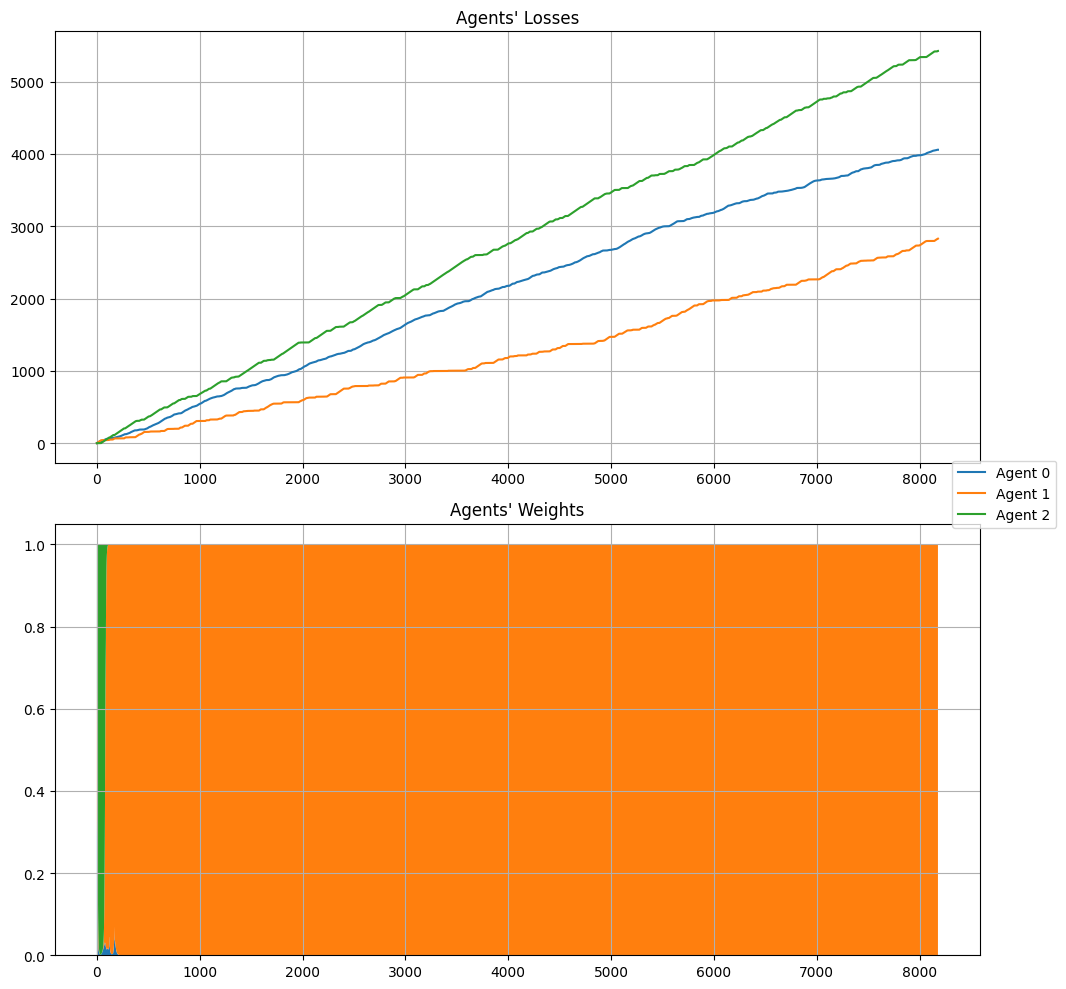

In [8]:
oamp.plot_stats()